### Import Library

In [50]:
# 이 중에서 안깔린 라이브러리가 있을 수 있음
import sys
import os
from typing import List, Dict, Tuple
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import lightgbm as lgb
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import seaborn as sns
import matplotlib.pyplot as plt
import pywt

sys.path.append(os.path.abspath('..'))
from func.utils import evaluate_model
import func.features as ft

### Load Data

In [51]:
data_path = "../../data/"  # 알아서 수정해 쓸 것

train = pd.read_csv(data_path+"train.csv").assign(_type="train")
test = pd.read_csv(data_path+"test.csv").assign(_type="test")
submission = pd.read_csv(data_path+"test.csv")
df = pd.concat([train, test], axis=0)

In [52]:
file_names = [
    "HOURLY_MARKET-DATA_COINBASE-PREMIUM-INDEX.csv",
    "HOURLY_MARKET-DATA_FUNDING-RATES_ALL_EXCHANGE.csv",
    "HOURLY_MARKET-DATA_LIQUIDATIONS_ALL_EXCHANGE_ALL_SYMBOL.csv",
    "HOURLY_MARKET-DATA_OPEN-INTEREST_ALL_EXCHANGE_ALL_SYMBOL.csv",
    "HOURLY_MARKET-DATA_TAKER-BUY-SELL-STATS_BINANCE.csv",
    "HOURLY_NETWORK-DATA_ADDRESSES-COUNT.csv",
    "HOURLY_NETWORK-DATA_BLOCK-BYTES.csv",
    "HOURLY_NETWORK-DATA_BLOCK-COUNT.csv",
    "HOURLY_NETWORK-DATA_BLOCK-INTERVAL.csv",
    "HOURLY_NETWORK-DATA_BLOCKREWARD.csv",
    "HOURLY_NETWORK-DATA_DIFFICULTY.csv",
    "HOURLY_NETWORK-DATA_FEES-TRANSACTION.csv",
    "HOURLY_NETWORK-DATA_FEES.csv",
    "HOURLY_NETWORK-DATA_HASHRATE.csv",
    "HOURLY_NETWORK-DATA_SUPPLY.csv",
    "HOURLY_NETWORK-DATA_TOKENS-TRANSFERRED.csv",
    "HOURLY_NETWORK-DATA_TRANSACTIONS-COUNT.csv",
    "HOURLY_NETWORK-DATA_UTXO-COUNT.csv",
    "HOURLY_NETWORK-DATA_VELOCITY.csv",
]

display(file_names)

file_dict: Dict[str, pd.DataFrame] = {
    f.replace(".csv", ""): pd.read_csv(data_path+f) for f in file_names
}

for _file_name, _df in tqdm(file_dict.items()):
    _rename_rule = {
        col: f"{col.lower()}" if col != "datetime" else "ID"
        for col in _df.columns
    }
    _df = _df.rename(_rename_rule, axis=1)
    df = df.merge(_df, on="ID", how="left")

['HOURLY_MARKET-DATA_COINBASE-PREMIUM-INDEX.csv',
 'HOURLY_MARKET-DATA_FUNDING-RATES_ALL_EXCHANGE.csv',
 'HOURLY_MARKET-DATA_LIQUIDATIONS_ALL_EXCHANGE_ALL_SYMBOL.csv',
 'HOURLY_MARKET-DATA_OPEN-INTEREST_ALL_EXCHANGE_ALL_SYMBOL.csv',
 'HOURLY_MARKET-DATA_TAKER-BUY-SELL-STATS_BINANCE.csv',
 'HOURLY_NETWORK-DATA_ADDRESSES-COUNT.csv',
 'HOURLY_NETWORK-DATA_BLOCK-BYTES.csv',
 'HOURLY_NETWORK-DATA_BLOCK-COUNT.csv',
 'HOURLY_NETWORK-DATA_BLOCK-INTERVAL.csv',
 'HOURLY_NETWORK-DATA_BLOCKREWARD.csv',
 'HOURLY_NETWORK-DATA_DIFFICULTY.csv',
 'HOURLY_NETWORK-DATA_FEES-TRANSACTION.csv',
 'HOURLY_NETWORK-DATA_FEES.csv',
 'HOURLY_NETWORK-DATA_HASHRATE.csv',
 'HOURLY_NETWORK-DATA_SUPPLY.csv',
 'HOURLY_NETWORK-DATA_TOKENS-TRANSFERRED.csv',
 'HOURLY_NETWORK-DATA_TRANSACTIONS-COUNT.csv',
 'HOURLY_NETWORK-DATA_UTXO-COUNT.csv',
 'HOURLY_NETWORK-DATA_VELOCITY.csv']

100%|██████████| 19/19 [00:00<00:00, 32.15it/s]


In [53]:
df.isnull().sum().sort_values(ascending=False)

target                         2792
block_bytes                      54
funding_rates                    32
transactions_count_mean          28
supply_total                     28
supply_new                       28
fees_transaction_mean            24
difficulty                       24
block_interval                   24
fees_transaction_mean_usd        24
fees_block_mean_usd              24
fees_block_mean                  24
tokens_transferred_mean          24
fees_reward_percent              24
coinbase_premium_gap              6
coinbase_premium_index            6
taker_buy_sell_ratio              5
taker_sell_volume                 5
taker_sell_ratio                  5
taker_buy_volume                  5
taker_buy_ratio                   5
block_count                       4
open_interest                     4
transactions_count_total          4
utxo_count                        1
_type                             0
ID                                0
short_liquidations          

In [54]:
# 1. 결측치 처리 - 앞/뒤 보간법 (forward/backward fill)
tmp_df = df.drop(['ID', 'target', '_type'], axis=1)

# df_ffill = df_new.fillna(method='ffill')  # 앞의 값을 사용하여 결측치 채움
# df_bfill = df_new.fillna(method='bfill')  # 뒤의 값을 사용하여 결측치 채움

# 2. 결측치 처리 - 선형 보간법 (linear interpolation)
df_interpolated = tmp_df.interpolate(method='linear')

# 3. 결측치 처리 - 평균값으로 대체
# df_mean_filled = df_new.fillna(eda_df.mean())

df.update(df_interpolated)

# 결측치 처리 후 확인
print(df.isnull().sum())

ID                                0
target                         2792
_type                             0
coinbase_premium_gap              0
coinbase_premium_index            0
funding_rates                     0
long_liquidations                 0
short_liquidations                0
long_liquidations_usd             0
short_liquidations_usd            0
open_interest                     0
taker_buy_volume                  0
taker_sell_volume                 0
taker_buy_ratio                   0
taker_sell_ratio                  0
taker_buy_sell_ratio              0
addresses_count_active            0
addresses_count_sender            0
addresses_count_receiver          0
block_bytes                       0
block_count                       0
block_interval                    0
blockreward                       0
blockreward_usd                   0
difficulty                        0
fees_transaction_mean             0
fees_transaction_mean_usd         0
fees_transaction_median     

### Feature engineering

In [55]:
# eda 에서 파악한 차이와 차이의 음수, 양수 여부를 새로운 피쳐로 생성
df = df.assign(
    liquidation_diff=df["long_liquidations"] - df["short_liquidations"],
    liquidation_usd_diff=df["long_liquidations_usd"] - df["short_liquidations_usd"],
    volume_diff=df["taker_buy_volume"] - df["taker_sell_volume"],
    liquidation_diffg=np.sign(df["long_liquidations"] - df["short_liquidations"]),
    liquidation_usd_diffg=np.sign(df["long_liquidations_usd"] - df["short_liquidations_usd"]),
    volume_diffg=np.sign(df["taker_buy_volume"] - df["taker_sell_volume"]),
    buy_sell_volume_ratio=df["taker_buy_volume"] / (df["taker_sell_volume"] + 1),
)

# category, continuous 열을 따로 할당해둠
category_cols = ["liquidation_diffg", "liquidation_usd_diffg", "volume_diffg"]
conti_cols = [_ for _ in df.columns if _ not in ["ID", "target", "_type"]] + [
    "buy_sell_volume_ratio",
    "liquidation_diff",
    "liquidation_usd_diff",
    "volume_diff",
]

* 🔥 피처엔지니어링 함수 추가

In [56]:
# 적용 
df = ft.make_date(df, 'ID') # 날짜 피처
df = ft.make_diff_change(df, ['open_interest']) # 변동성, 차분 피처 
df = ft.make_longshort_ratio(df, 'long_liquidations', 'short_liquidations') # 롱/숏 비율
df = ft.make_liquidation_to_volume_ratio(df, 'long_liquidations', 'short_liquidations', 'taker_buy_volume', 'taker_sell_volume') # 청산/거래량 비율
df = ft.make_liquidation_usd_ratio(df, 'long_liquidations_usd', 'short_liquidations_usd') # 청산된 USD 롱/숏 비율
df = ft.make_funding_rate_position_change(df, 'funding_rates', 'long_liquidations_usd', 'short_liquidations_usd') # 펀딩 비율과 롱/숏 포지션 차이 곱
df = ft.make_premium_diff(df, 'coinbase_premium_gap', 'coinbase_premium_index') # 프리미엄 갭과 프리미엄 인덱스의 차이
df = ft.make_hashrate_to_difficulty(df, 'hashrate', 'difficulty') # 해시레이트와 난이도 간의 비율
df = ft.make_supply_change_rate(df, 'supply_new', 'supply_total') # 공급 변화율

conti_cols = conti_cols + ['open_interest_pct_change', 'open_interest_diff', 'long_short_ratio', 'liquidation_to_volume_ratio', 'liquidation_usd_ratio', 'funding_rate_position_change', 'premium_diff', 'hashrate_to_difficulty', 'supply_change_rate']

In [57]:
# 위의 함수들을 실행한다.

# 모든 수치형 컬럼에 대한 지수이동평균 계산
ema_dfs = []
for c in conti_cols:
    ema_df = ft.make_EMA(df, [c], 7)
    ema_df.columns = [f"{c}_moving_avg_7"]
    ema_dfs.append(ema_df)

# 원본 데이터프레임과 새로 계산된 EMA 데이터프레임들을 병합
df = pd.concat([df] + ema_dfs, axis=1)
    

# 모든 수치형 컬럼에 대한 Wavelet transform을 계산
wt_dfs = []
for c in conti_cols:
    wt_series = pd.Series(ft.make_WT(df, c), name=f"{c}_WT", index=df.index)
    wt_dfs.append(wt_series)

# 원본 데이터프레임과 새로 계산된 WT 시리즈들을 병합
df = pd.concat([df] + wt_dfs, axis=1)

# 최대 24시간의 shift 피쳐를 계산
shift_list = ft.make_shift(
    df=df, conti_cols=conti_cols, intervals=[_ for _ in range(1, 24)]
)

In [58]:
df = pd.concat([df, pd.concat(shift_list, axis=1)], axis=1)

_target = df["target"]
df = df.ffill().fillna(-999).assign(target = _target)
df = df.loc[:, ~df.columns.duplicated()]

train_df = df.loc[df["_type"]=="train"].drop(columns=["_type"])
test_df = df.loc[df["_type"]=="test"].drop(columns=["_type"])

### Model Training

#### lightGBM 학습

In [59]:
# train_test_split 으로 valid set, train set 분리
x_train, x_valid, y_train, y_valid = train_test_split(
    train_df.drop(["target", "ID"], axis = 1), 
    train_df["target"].astype(int), 
    test_size=0.2,
    random_state=42,
)

In [60]:
pd.DataFrame(y_train).value_counts()

target
2         2926
1         2866
3          625
0          591
Name: count, dtype: int64

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


acc: 0.4537671232876712, auroc: 0.6538836776457936

lgb_model 모델 평가

분류 보고서:
              precision    recall  f1-score   support

     Class 0       0.18      0.01      0.03       149
     Class 1       0.44      0.53      0.48       678
     Class 2       0.47      0.58      0.52       745
     Class 3       0.18      0.01      0.02       180

    accuracy                           0.45      1752
   macro avg       0.32      0.28      0.26      1752
weighted avg       0.41      0.45      0.41      1752

혼동 행렬:


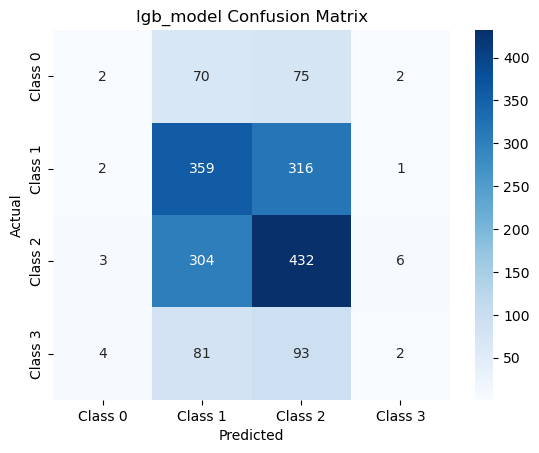

In [61]:
# lgb dataset
train_data = lgb.Dataset(x_train, label=y_train)
valid_data = lgb.Dataset(x_valid, label=y_valid, reference=train_data)

# lgb params
params = {
    "boosting_type": "gbdt",
    "objective": "multiclass",
    "metric": "multi_logloss",
    "num_class": 4,
    "num_leaves": 50,
    "learning_rate": 0.05,
    "n_estimators": 30,
    "random_state": 42,
    "verbose": 0,
}

# lgb train
lgb_model = lgb.train(
    params=params,
    train_set=train_data,
    valid_sets=valid_data,
)

# lgb predict
y_valid_pred = lgb_model.predict(x_valid)
y_valid_pred_class = np.argmax(y_valid_pred, axis = 1)

# score check
accuracy = accuracy_score(y_valid, y_valid_pred_class)
auroc = roc_auc_score(y_valid, y_valid_pred, multi_class="ovr")

print(f"acc: {accuracy}, auroc: {auroc}")

# 추가된 confusion matrix 구현 부분
evaluate_model(y_valid, y_valid_pred_class, "lgb_model")

In [36]:
# from lightgbm import LGBMClassifier

# # train_test_split 으로 valid set, train set 분리
# x_train, x_valid, y_train, y_valid = train_test_split(
#     train_df.drop(["target", "ID"], axis = 1), 
#     train_df["target"].astype(int), 
#     test_size=0.2,
#     random_state=42,
# )

# # LightGBM 모델 생성 및 학습
# lgb_model = LGBMClassifier(
#     boosting_type="gbdt",
#     objective="multiclass",
#     num_class=4,
#     num_leaves=50,
#     learning_rate=0.05,
#     n_estimators=30,
#     random_state=42,
#     verbose=-1
# )

# lgb_model.fit(
#     x_train, 
#     y_train,
#     eval_set=[(x_valid, y_valid)],
#     eval_metric='multi_logloss'
# )


LGBMClassifier(learning_rate=0.05, n_estimators=30, num_class=4, num_leaves=50,
               objective='multiclass', random_state=42, verbose=-1)

#### XGBoost 학습

In [23]:
# import xgboost as xgb
# from sklearn.ensemble import VotingClassifier

# # train_test_split 으로 valid set, train set 분리
# x_train, x_valid, y_train, y_valid = train_test_split(
#     train_df.drop(["target", "ID"], axis = 1), 
#     train_df["target"].astype(int), 
#     test_size=0.2,
#     random_state=42,
# )

# xgb_params = {
#     'objective': 'multi:softprob',
#     'num_class': 4,
#     'learning_rate': 0.05,
#     'max_depth': 6,
#     'n_estimators': 100,
#     'random_state': 42
# }

# # XGBoost 모델 학습 및 성능 체크
# xgb_model = xgb.XGBClassifier(**xgb_params)
# xgb_model.fit(x_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, num_class=4,
              num_parallel_tree=None, ...)

#### Ensenble

In [41]:
# from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier
# from sklearn.model_selection import cross_val_score
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import KFold
# from sklearn.base import BaseEstimator, ClassifierMixin, clone
# from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
# from sklearn.utils.multiclass import unique_labels

# rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# # 데이터 준비
# X = train_df.drop(["target", "ID"], axis=1)
# y = train_df["target"].astype(int)

# # 교차 검증을 위한 KFold 정의
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# # 1. Voting 앙상블
# voting_hard = VotingClassifier(
#     estimators=[('lgb', lgb_model), ('xgb', xgb_model), ('rf', rf_model)],
#     voting='hard'
# )

# voting_soft = VotingClassifier(
#     estimators=[('lgb', lgb_model), ('xgb', xgb_model), ('rf', rf_model)],
#     voting='soft'
# )

# # 2. Bagging 앙상블
# bagging = BaggingClassifier(base_estimator=lgb_model, n_estimators=10, random_state=42)

# # 3. Stacking 앙상블

# class StackingEnsemble(BaseEstimator, ClassifierMixin):
#     def __init__(self, base_models, meta_model, n_folds=5):
#         self.base_models = base_models
#         self.meta_model = meta_model
#         self.n_folds = n_folds

#     def fit(self, X, y):
#         # Check that X and y have correct shape
#         X, y = check_X_y(X, y)
#         # Store the classes seen during fit
#         self.classes_ = unique_labels(y)

#         self.base_models_ = [list() for _ in self.base_models]
#         self.meta_model_ = clone(self.meta_model)
#         kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=42)
        
#         out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        
#         for i, model in enumerate(self.base_models):
#             for train_index, holdout_index in kfold.split(X, y):
#                 instance = clone(model)
#                 self.base_models_[i].append(instance)
#                 instance.fit(X[train_index], y[train_index])
#                 y_pred = instance.predict_proba(X[holdout_index])
#                 out_of_fold_predictions[holdout_index, i] = y_pred[:, 1]
        
#         self.meta_model_.fit(out_of_fold_predictions, y)
#         return self

#     def predict(self, X):
#         # Check is fit had been called
#         check_is_fitted(self)
#         # Input validation
#         X = check_array(X)
#         meta_features = np.column_stack([
#             np.column_stack([model.predict_proba(X)[:, 1] for model in base_models]).mean(axis=1)
#             for base_models in self.base_models_ ])
#         return self.meta_model_.predict(meta_features)

#     def predict_proba(self, X):
#         # Check is fit had been called
#         check_is_fitted(self)
#         # Input validation
#         X = check_array(X)
#         meta_features = np.column_stack([
#             np.column_stack([model.predict_proba(X)[:, 1] for model in base_models]).mean(axis=1)
#             for base_models in self.base_models_ ])
#         return self.meta_model_.predict_proba(meta_features)

# stacking = StackingEnsemble(
#     base_models=(lgb_model, xgb_model, rf_model),
#     meta_model=LogisticRegression()
# )

# from sklearn.model_selection import cross_val_predict

# accuracy_scores = cross_val_score(stacking, X, y, cv=kf, scoring='accuracy', error_score='raise')
# # AUROC 계산
# if hasattr(stacking, "predict_proba"):
#     y_pred_proba = cross_val_predict(stacking, X, y, cv=kf, method='predict_proba')
#     auroc_score = roc_auc_score(y, y_pred_proba, multi_class='ovr')
# else:
#     auroc_score = None

# print("Stacking")
# print(f"  - 평균 정확도: {accuracy_scores.mean()} (+/- {accuracy_scores.std() * 2})")
# if auroc_score:
#     print(f"  - AUROC: {auroc_score}")
# else:
#     print("  - AUROC: Not available")
# print()



Stacking
  - 평균 정확도: 0.44257990867579905 (+/- 0.018654518918552982)
  - AUROC: 0.6156466222603283



In [42]:
# from sklearn.metrics import roc_auc_score
# from sklearn.model_selection import cross_val_predict

# # 모델 리스트 (VotingHard 제외)
# models = [lgb_model, xgb_model, rf_model, voting_soft, bagging]
# model_names = ['LightGBM', 'XGBoost', 'RandomForest', 'VotingSoft', 'Bagging']

# # 각 모델의 교차 검증 수행
# for name, model in zip(model_names, models):
#     # 정확도 계산
#     accuracy_scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')
    
#     # AUROC 계산
#     if hasattr(model, "predict_proba"):
#         y_pred_proba = cross_val_predict(model, X, y, cv=kf, method='predict_proba')
#         auroc_score = roc_auc_score(y, y_pred_proba, multi_class='ovr')
#     else:
#         auroc_score = None
    
#     print(f"{name}:")
#     print(f"  - 평균 정확도: {accuracy_scores.mean()} (+/- {accuracy_scores.std() * 2})")
#     if auroc_score:
#         print(f"  - AUROC: {auroc_score}")
#     else:
#         print("  - AUROC: Not available")
#     print()


LightGBM:
  - 평균 정확도: 0.44771689497716893 (+/- 0.023166485651079118)
  - AUROC: 0.6441506299157067

XGBoost:
  - 평균 정확도: 0.45468036529680367 (+/- 0.022071852125309502)
  - AUROC: 0.6467366784309543

RandomForest:
  - 평균 정확도: 0.4328767123287672 (+/- 0.021130750615829398)
  - AUROC: 0.6331584839403167

VotingSoft:
  - 평균 정확도: 0.44908675799086756 (+/- 0.019948119779728574)
  - AUROC: 0.6547739170883



/data/ephemeral/home/miniconda/envs/ensenble/lib/python3.8/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/data/ephemeral/home/miniconda/envs/ensenble/lib/python3.8/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/data/ephemeral/home/miniconda/envs/ensenble/lib/python3.8/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/data/ephemeral/home/miniconda/envs/ensenble/lib/python3.8/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/data/ephemeral/home/miniconda/envs/ensenble/lib/python3.8/site-packages/sklearn/ensemble/_base.py:156: Futu

Bagging:
  - 평균 정확도: 0.45547945205479456 (+/- 0.029495384218664225)
  - AUROC: 0.6549400279939801



In [ ]:

# # 최종 모델 선택 및 전체 데이터로 학습 (AUROC 기준)
# best_model = models[np.argmax([
#     roc_auc_score(y, cross_val_predict(model, X, y, cv=kf, method='predict_proba'), multi_class='ovr')
#     if hasattr(model, "predict_proba") else 0 
#     for model in models
# ])]

# best_model.fit(X, y)

# # 테스트 데이터에 대한 예측
# X_test = test_df.drop(["target", "ID"], axis=1)
# y_test_pred = best_model.predict(X_test)
# if hasattr(best_model, "predict_proba"):
#     y_test_pred_proba = best_model.predict_proba(X_test)

# # 제출 파일 생성
# submission = submission.assign(target=y_test_pred)
# submission.to_csv("output_best_ensemble.csv", index=False)

# print(f"Best model: {type(best_model).__name__}")

### Inference

앙상블의 inference & save 과정.